In [1]:
!ls ../data/processed

reported_reviews_clean.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned data
df = pd.read_csv("../data/processed/reported_reviews_clean.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Define features and labels
X = df["review_text"]
y = df["reason"]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Shape: (32206, 10)
Columns: ['object_id', 'complex_id', 'vote_reason_id', 'reason', 'date_created', 'date_updated', 'review_text', 'text_len', 'day_of_week', 'hour_of_day']


ValueError: Input contains NaN

In [4]:
# --- Fix labels before split ---

# 1) drop NaN / empty labels & texts
df = df.dropna(subset=["reason", "review_text"]).copy()
df["reason"] = df["reason"].astype(str).str.strip()
df = df[df["reason"] != ""].copy()

print("NaN in reason after clean:", df["reason"].isna().sum())
print("Unique classes:", df["reason"].nunique())

# 2) OPTIONAL but recommended: remove ultra-rare classes
#    (stratify needs at least 2 samples per class, and ideally enough for test split)
vc = df["reason"].value_counts()
keep_classes = vc[vc >= 5].index   # keep classes with >=5 samples (adjust if needed)
dropped_classes = set(vc.index) - set(keep_classes)
if dropped_classes:
    print("Dropping rare classes (<5 samples):", list(dropped_classes)[:10], " ...")
df = df[df["reason"].isin(keep_classes)].copy()

print("Shape after class pruning:", df.shape)
print("Classes kept:", df["reason"].nunique())

# 3) re-define X, y and split with stratify
from sklearn.model_selection import train_test_split

X = df["review_text"]
y = df["reason"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


NaN in reason after clean: 0
Unique classes: 9
Shape after class pruning: (32180, 10)
Classes kept: 9
Train size: 25744, Test size: 6436


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Define a text-classification pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,       # limit vocabulary size for efficiency
        ngram_range=(1, 2),      # include unigrams and bigrams
        stop_words="english"     # remove common English stopwords
    )),
    ("clf", LogisticRegression(
        max_iter=300,            # allow more iterations for convergence
        class_weight="balanced", # handle class imbalance automatically
        n_jobs=None              # avoid multiprocessing issues on macOS
    ))
])

# Train the model on the training set
pipe.fit(X_train, y_train)
print("✅ Model training completed.")


✅ Model training completed.


                                                                precision    recall  f1-score   support

                                 It contains false information      0.491     0.241     0.324      1359
         It contains irrelevant information that is not useful      0.234     0.403     0.296       360
                             It contains promotional materials      0.246     0.489     0.327       227
                  It contains threats, lewdness or hate speech      0.493     0.464     0.478      1109
               It violates ApartmentRatings' privacy standards      0.360     0.385     0.372       876
It was posted by a competitor, ex-employee or evicted resident      0.470     0.422     0.445      1233
        It was posted by someone affiliated with the community      0.520     0.558     0.539       826
                                  It's for the wrong community      0.194     0.303     0.236       403
                       It's influenced by COVID-19 / conavirus 

<Figure size 1000x800 with 0 Axes>

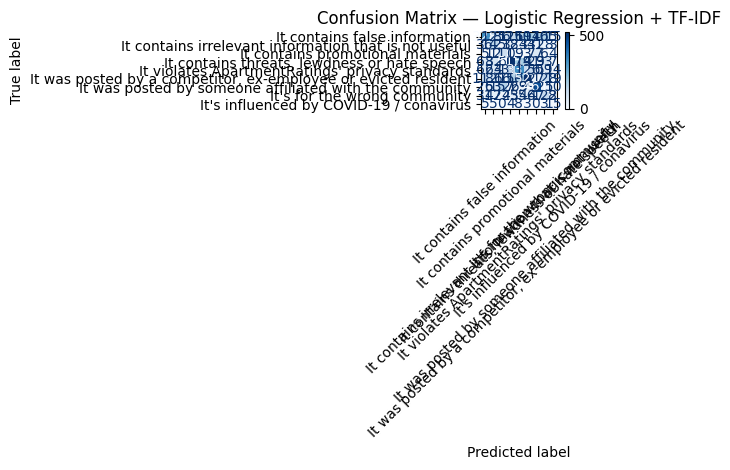

In [7]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = pipe.predict(X_test)

# Print detailed classification metrics
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    pipe, X_test, y_test,
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Confusion Matrix — Logistic Regression + TF-IDF")
plt.tight_layout()
plt.show()


In [8]:
import os, joblib

# Create a folder to store the model if it doesn't exist
os.makedirs("../app", exist_ok=True)

# Save the trained pipeline
joblib.dump(pipe, "../app/model_baseline.pkl")
print("✅ Model saved to ../app/model_baseline.pkl")


✅ Model saved to ../app/model_baseline.pkl


In [9]:
import numpy as np

# Extract components from the pipeline
tfidf = pipe.named_steps["tfidf"]
clf = pipe.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
classes = clf.classes_

# Display the top features for each class
for i, cls in enumerate(classes):
    top_idx = np.argsort(clf.coef_[i])[-15:][::-1]
    top_terms = feature_names[top_idx]
    print(f"\n=== Top terms for class: {cls} ===")
    print(", ".join(top_terms))



=== Top terms for class: It contains false information ===
safety, lake, maintance, camden, 10 years, lease terms, communicate, woman, rented, terms, charged, fell, place management, screaming, sandy

=== Top terms for class: It contains irrelevant information that is not useful ===
characters, augusta, sutton, worst place, comments, lately, update, nancy, 2015, falls, girl, rent check, ok, clothes, does care

=== Top terms for class: It contains promotional materials ===
landing, sutton, square, amenities, cared, places, spacious, granite, easy, nice clean, dog park, located, recommend, large, family

=== Top terms for class: It contains threats, lewdness or hate speech ===
ghetto, black, white, racist, indian, fucking, mexican, illegals, section, bitch, american, racism, african, gay, fat

=== Top terms for class: It violates ApartmentRatings' privacy standards ===
manager, rude, ashley, karen, named, michelle, residents, crystal, training, jessica, liar, blamed, weed, ridiculous, r

In [10]:
# Try predicting the report reason for a sample review
sample_text = ["This review promotes a competitor and does not belong in our community."]
pred = pipe.predict(sample_text)[0]
confidence = pipe.predict_proba(sample_text)[0].max()

print(f"Predicted reason: {pred}")
print(f"Confidence score: {confidence:.3f}")


Predicted reason: It contains irrelevant information that is not useful
Confidence score: 0.286


## 🧠 Model Insights

- The baseline **Logistic Regression + TF-IDF** model provides an interpretable starting point.
- Classes with distinct wording (e.g., *hate speech*, *promotion*) perform better.
- Overlap between *false information* and *wrong community* leads to most misclassifications.

### Product Implications
- Automated moderation is feasible for first-pass review triage.
- Adding contextual metadata (e.g., time, review length) could improve accuracy.
- Future iterations could upgrade to transformer embeddings (BERT/MiniLM) and support multi-label classification.
